# Analyze data downloaded from Google Takeout

Below I used scripts from https://habr.com/ru/post/581062/ and https://github.com/nurkiewicz/google-location-history

Not all of them work in new version pf pandas, so I fix errors.
I also made some optimization (reuse palette, as its calucaltion takes a lot of time)

In [2]:
import logging
import logging.config

import pandas as pd
import numpy as np

# pip install geopandas works well in Linux, but not in Windows.
# So I used WSL to run this script.
import geopandas as gp
import shapely.geometry as sg
import datetime as dt
from matplotlib import cm
from matplotlib.lines import Line2D

In [3]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger( )

typical piece of data looks like this  
 {  
    "latitudeE7": 549443172,  
    "longitudeE7": 831926944,  
    "accuracy": 65,  
    "source": "UNKNOWN",  
    "deviceTag": 3553195,  
    "timestamp": "2013-12-14T15:19:40.228Z"  
  }

In [4]:
def extract_activity(record):
    try:
        return record["activity"][0]["activity"][0]["type"]
    except:
        return "MISSING"

def parse_json(json):
    points = [sg.Point(xy) for xy in zip(json.locations.apply(lambda x: x["longitudeE7"] / 10000000),
                                    json.locations.apply(lambda x: x["latitudeE7"] / 10000000))]
    df = gp.GeoDataFrame(geometry=points)
    locations = json.locations
    logger.debug(type(locations))
    df["timestamp"] = locations.apply(lambda x: pd.to_datetime(x["timestamp"]))
    df["accuracy"] = locations.apply(lambda x: x["accuracy"])
    df["velocity"] = locations.apply(lambda x: x.get("velocity", None))
    df["heading"] = locations.apply(lambda x: x.get("heading", None))
    df["altitude"] = locations.apply(lambda x: x.get("altitude", None))
    df["activity"] = locations.apply(extract_activity)
    return df


In [6]:
# this file can be downloaded here https://takeout.google.com
fullpath_json="../data/Location_History/Records.json"
%time df = parse_json(pd.read_json(fullpath_json))

CPU times: user 56.2 s, sys: 1.17 s, total: 57.3 s
Wall time: 57.3 s


## Some statistics

In [7]:
df["activity"].unique()

array(['MISSING', 'STILL', 'ON_FOOT', 'TILTING', 'UNKNOWN', 'IN_VEHICLE',
       'EXITING_VEHICLE', 'ON_BICYCLE'], dtype=object)

In [8]:
logger.info(f"velocity : {df['velocity'].min()} .. {df['velocity'].max()} (km/h)")
logger.info(f"heading : {df['heading'].min()} .. {df['heading'].max()}")
logger.info(f"altitude : {df['altitude'].min()} .. {df['altitude'].max()} (m?)")

INFO:root:velocity : 0.0 .. 27.0 (km/h)
INFO:root:heading : 0.0 .. 359.0
INFO:root:altitude : -1206.0 .. 175.0


## Load Map of the World

In [9]:
# http://thematicmapping.org/downloads/world_borders.php
# TM_WORLD_BORDERS-0.3.zip (3,380 kB)
world = gp.read_file('../data/raw/TM_WORLD_BORDERS-0.3.shp')

In [10]:
def draw_map(df, box=sg.box(-140, -20, 140, 70)):
    box_only = df[df.geometry.within(box)]
    minx, miny, maxx, maxy = box.bounds
    logger.info("plot map of the world ...")
    base = world.plot(color='white', edgecolor='silver', figsize=(16,8))
    base.set_xlim(minx, maxx)
    base.set_ylim(miny, maxy)
    logger.info("plot markers on the map of the world ...")
    ax = box_only.plot(ax=base, marker='o', markersize=8)

INFO:root:plot map of the world ...
INFO:root:plot markers on the map of the world ...


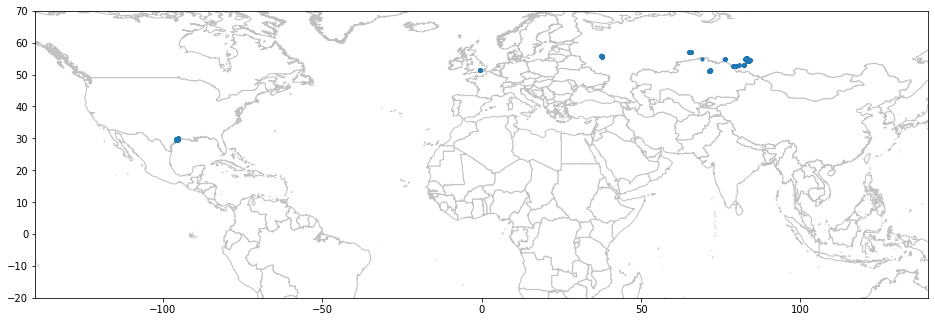

In [11]:
draw_map(df, sg.box(-140, -20, 140, 70))

# Location plotter

In [12]:
# precalculate some columns:
df["seconds"] = df["timestamp"].values.astype(int)

In [13]:
class C_location_plotter():
    def __init__(self):
        self._box_ = sg.box(-130, 10, 140, 70)
        self._palette_ = None

    def set_box(self, box):
        self._box_ = box

    @staticmethod
    def seconds(timestamp):
        return timestamp.to_pydatetime().timestamp()

    def get_list_of_cmap(self, df2, cmap):
        logger.info("get_list_of_cmap ...")
        min_ts = df2["seconds"].min()
        max_ts = df2["seconds"].max()
        lst_of_cmap = df2["seconds"].apply(lambda ts: list(cmap((ts - min_ts) / (max_ts - min_ts)))).to_list()
        # array=df2.timestamp.apply(lambda ts: cmap((seconds(ts) - min_ts) / (max_ts - min_ts))).tolist()
        return lst_of_cmap

    def compute_legend(self, df, ax, cmap, steps):
        logger.info("compute legend ...")
        vals = [x / (steps - 1) for x in range(steps)]
        custom_lines = [Line2D([0], [0], color=cmap(step), lw=4) for step in vals]
        labels = [df.timestamp.quantile(step).strftime("%Y-%m-%d") for step in vals]
        ax.legend(custom_lines, labels, loc="lower right")

    def set_palette(self, lst_of_cmap):
        logger.info("set palette ...")
        self._palette_ = lst_of_cmap

    def reset_palette(self):
        logger.info("reset palette ...")
        self._palette_ = None

    def get_palette(self, lst_of_cmap):
        logger.info("get palette ...")
        return self._palette_

    def calc_palette(self, df):
        logger.info("calculate palette ...")
        df_in_box = df[df.geometry.within(self._box_)]
        cmap = cm.get_cmap('viridis')
        lst_of_cmap = self.get_list_of_cmap(df_in_box, cmap)
        self.set_palette(lst_of_cmap)

    def draw_map_time(self, df):
        box_only = df[df.geometry.within(self._box_)]
        minx, miny, maxx, maxy = self._box_.bounds

        logger.info("plot world ...")
        base = world.plot(color='white', edgecolor='silver', figsize=(12,12))
        base.set_xlim(minx, maxx)
        base.set_ylim(miny, maxy)
        cmap = cm.get_cmap('viridis')
        
        if not self._palette_:
            logger.info("calculate palette ...")
            pal = self.calculate_pal(box_only, cmap)
            self.set_palette(pal)
        else:
            logger.info("use available palette ...")

        logger.info("plot markers ...")
        ax = box_only.plot(ax=base, marker='o', color=self._palette_, markersize=8)

        logger.info("compute and plot legend ...")
        self.compute_legend(box_only, ax, cmap, 5)
        logger.info("done.")


In [14]:
is_interactive_plot = False
if is_interactive_plot:
  %matplotlib ipympl
else:
  %matplotlib inline

## Map with All Points

In [18]:
world_plotter = C_location_plotter()
world_plotter.set_box(box=sg.box(-130, 10, 140, 70))
world_plotter.calc_palette(df)


INFO:root:calculate palette ...
INFO:root:get_list_of_cmap ...
INFO:root:set palette ...


INFO:root:plot world ...
INFO:root:use available palette ...
INFO:root:plot markers ...
INFO:root:compute and plot legend ...
INFO:root:compute legend ...
INFO:root:done.


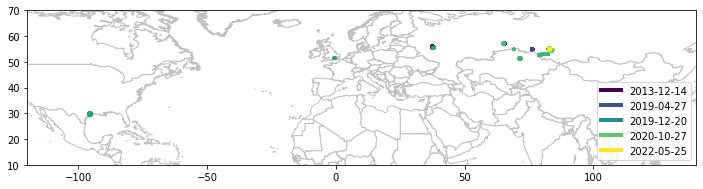

In [19]:
world_plotter.draw_map_time(df)

### Novosibirsk

In [20]:
# Nsk
nsk_plotter = C_location_plotter()
nsk = (83, 55)
nsk_plotter.set_box(box=sg.box(nsk[0]-0.5, nsk[1]-1, nsk[0]+1.2, nsk[1]+0.15))
nsk_plotter.calc_palette(df)


INFO:root:calculate palette ...
INFO:root:get_list_of_cmap ...
INFO:root:set palette ...


INFO:root:plot world ...
INFO:root:use available palette ...
INFO:root:plot markers ...
INFO:root:compute and plot legend ...
INFO:root:compute legend ...
INFO:root:done.


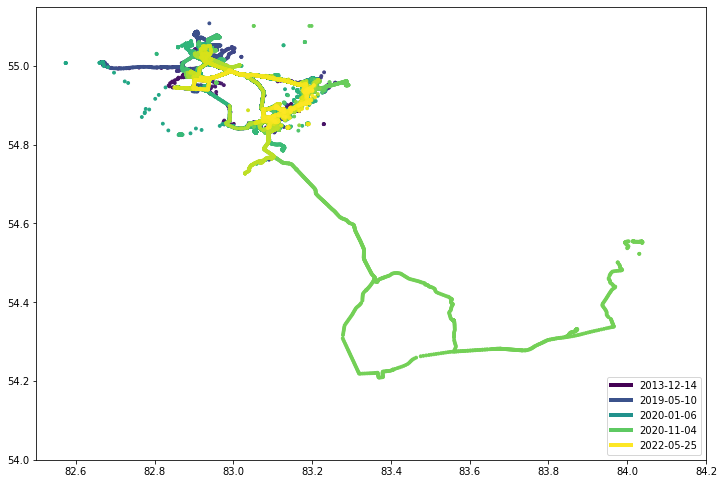

In [21]:
nsk_plotter.draw_map_time(df)


INFO:root:plot world ...
INFO:root:use available palette ...
INFO:root:plot markers ...
INFO:root:compute and plot legend ...
INFO:root:compute legend ...
INFO:root:done.


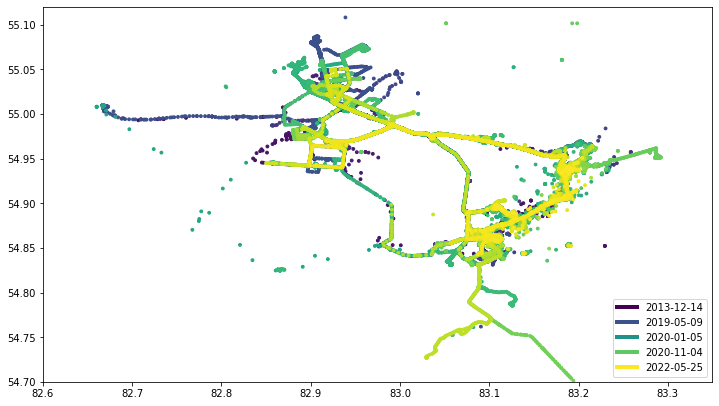

In [24]:
# Zoom in
nsk_plotter.set_box(box=sg.box(nsk[0]-0.4, nsk[1]-0.3, nsk[0]+0.35, nsk[1]+0.12))
nsk_plotter.draw_map_time(df)


### Houston

In [27]:
hst_plotter = C_location_plotter()
hst = (-95.36, 29.76)
hst_plotter.set_box(box=sg.box(hst[0]-0.6, hst[1]-0.3, hst[0]+0.2, hst[1]+0.3))
hst_plotter.calc_palette(df)

INFO:root:calculate palette ...
INFO:root:get_list_of_cmap ...
INFO:root:set palette ...


INFO:root:plot world ...
INFO:root:use available palette ...
INFO:root:plot markers ...
INFO:root:compute and plot legend ...
INFO:root:compute legend ...
INFO:root:done.


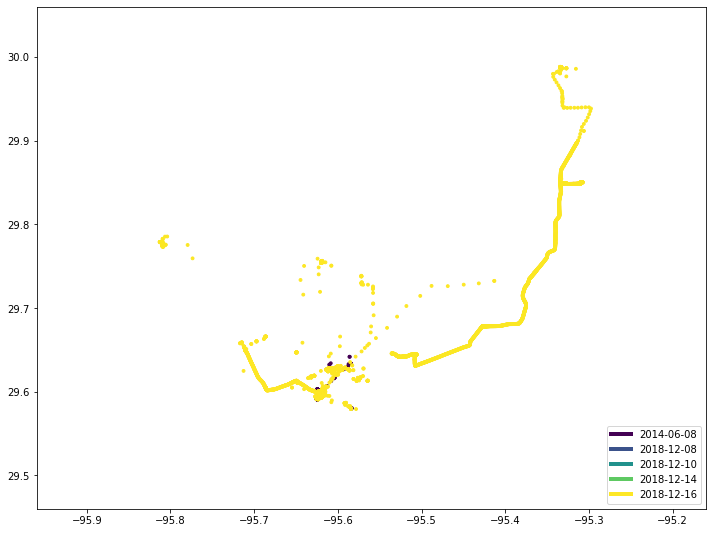

In [28]:
hst_plotter.draw_map_time(df)

## Activity at my Home

INFO:root:calculate palette ...
INFO:root:get_list_of_cmap ...
INFO:root:set palette ...
INFO:root:plot world ...
INFO:root:use available palette ...
INFO:root:plot markers ...
INFO:root:compute and plot legend ...
INFO:root:compute legend ...
INFO:root:done.


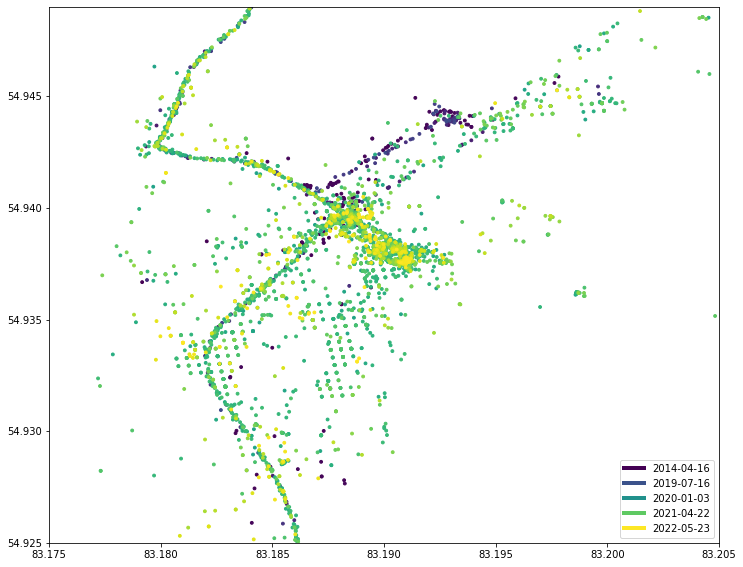

In [29]:
# Nsk
# nsk_location_plotter.draw_map_time(df[df["activity"]=="ON_BICYCLE"]) # not interesting
# nsk_location_plotter.draw_map_time(df[df["activity"]=="IN_VEHICLE"])  # the same as above

home_plotter = C_location_plotter()
klc = (83.175, 54.945)
home_plotter.set_box(box=sg.box(klc[0]+0.0, klc[1]-0.02, klc[0]+0.03, klc[1]+0.004))
home_plotter.calc_palette(df[df["activity"]=="IN_VEHICLE"])
home_plotter.draw_map_time(df[df["activity"]=="IN_VEHICLE"])

INFO:root:calculate palette ...
INFO:root:get_list_of_cmap ...
INFO:root:set palette ...
INFO:root:plot world ...
INFO:root:use available palette ...
INFO:root:plot markers ...
INFO:root:compute and plot legend ...
INFO:root:compute legend ...
INFO:root:done.


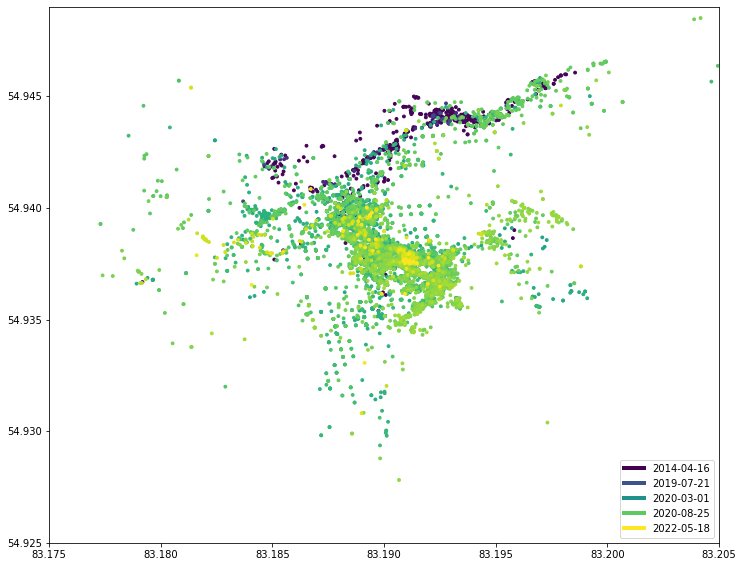

In [30]:
home_plotter.calc_palette(df[df["activity"]=="ON_FOOT"])
home_plotter.draw_map_time(df[df["activity"]=="ON_FOOT"])

## Activity Frequency

<AxesSubplot:xlabel='timestamp'>

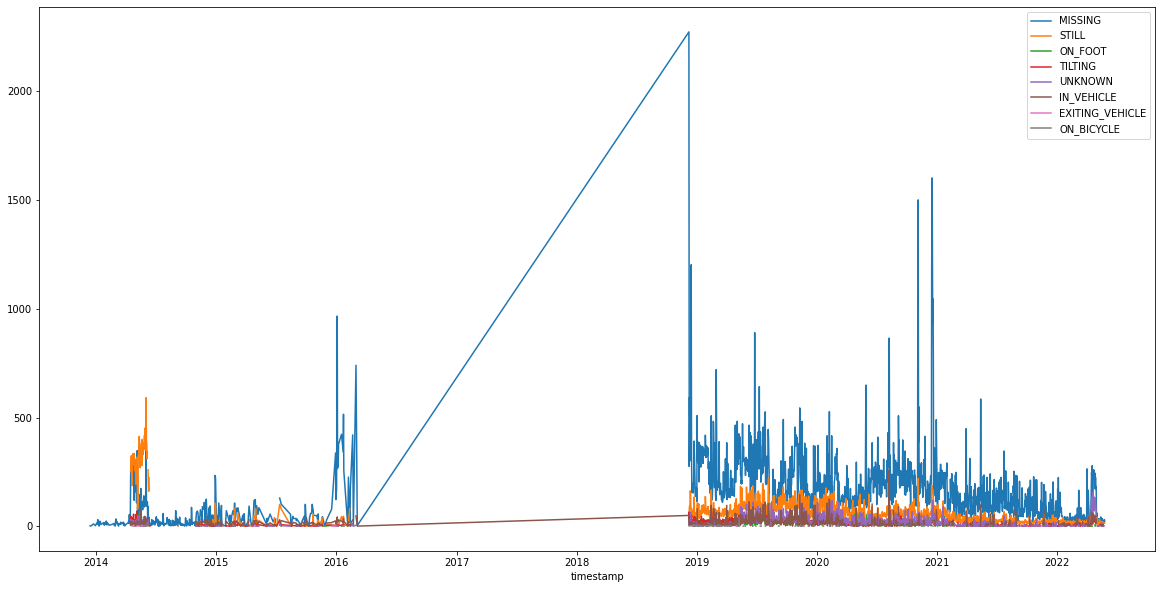

In [31]:
def dt_to_date(dt):
    return dt.date()

def aggregate_by(df, fun):
        tuples = [(activity, df[df.activity == activity].groupby(df.timestamp.apply(fun)).activity.agg('count')) 
            for activity in df.activity.drop_duplicates()]
        return pd.DataFrame(dict(tuples))

by_day = aggregate_by(df, dt_to_date)
by_day.plot(figsize=[20,10])

in 2016-2018 I use Nokia from Microsoft...

<AxesSubplot:xlabel='timestamp'>

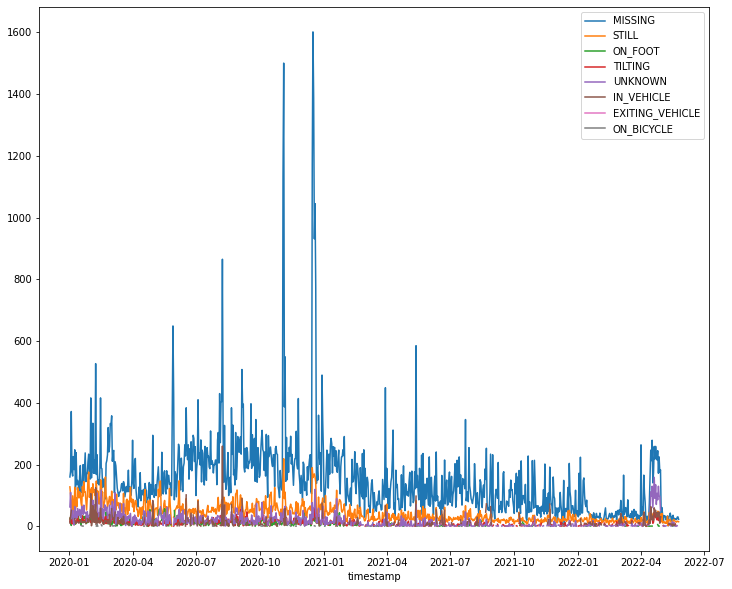

In [32]:
from datetime import date
by_day[by_day.index>date(2020,1,1)].plot(figsize=[12,10])

<AxesSubplot:xlabel='timestamp'>

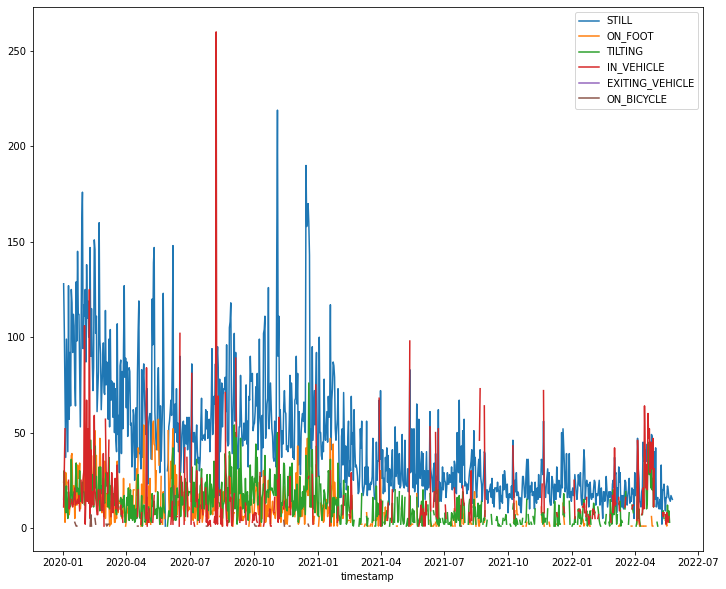

In [39]:
by_day_clear=by_day.drop(labels=["MISSING", "UNKNOWN"], axis=1)
by_day_clear[by_day_clear.index>date(2020,1,1)].plot(figsize=[12,10])

In [40]:
by_day[by_day.MISSING>1400]

,MISSING,STILL,ON_FOOT,TILTING,UNKNOWN,IN_VEHICLE,EXITING_VEHICLE,ON_BICYCLE
timestamp,,,,,,,,
2018-12-08,2272.0,26.0,4.0,9.0,5.0,50.0,NaN,NaN
2020-11-04,1500.0,219.0,28.0,50.0,56.0,25.0,1.0,1.0
2020-12-16,1601.0,158.0,19.0,20.0,28.0,NaN,NaN,NaN


INFO:root:busy_day calculated.


<AxesSubplot:xlabel='timestamp'>

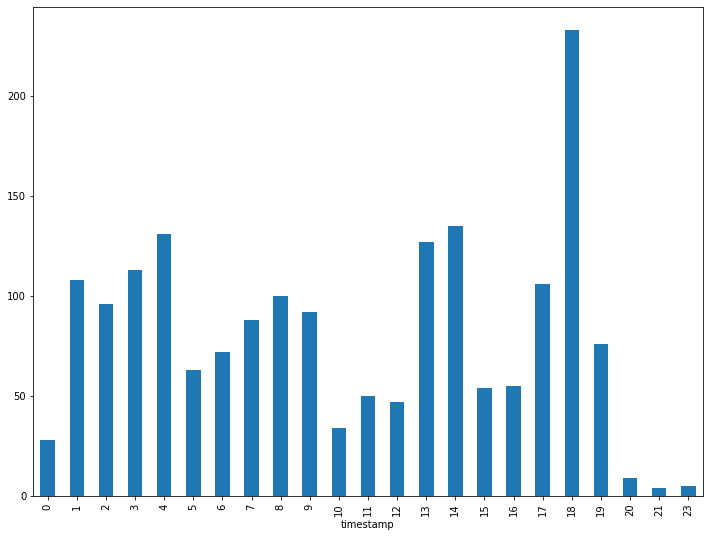

In [42]:
busy_day = df[df.timestamp.apply(dt_to_date) == dt.date(2020, 12, 16)]
logger.info("busy_day calculated.")
busy_day.groupby(busy_day.timestamp.dt.hour).agg('count')["geometry"].plot.bar(figsize=[12, 9])

## Altitude histogram

In [100]:
alt_max = df.altitude.max()
alt_min = df.altitude.min()
logger.info(f"altitude: {alt_min} .. {alt_max} ")


INFO:root:altitude: -1206.0 .. 175.0 


<AxesSubplot:ylabel='Frequency'>

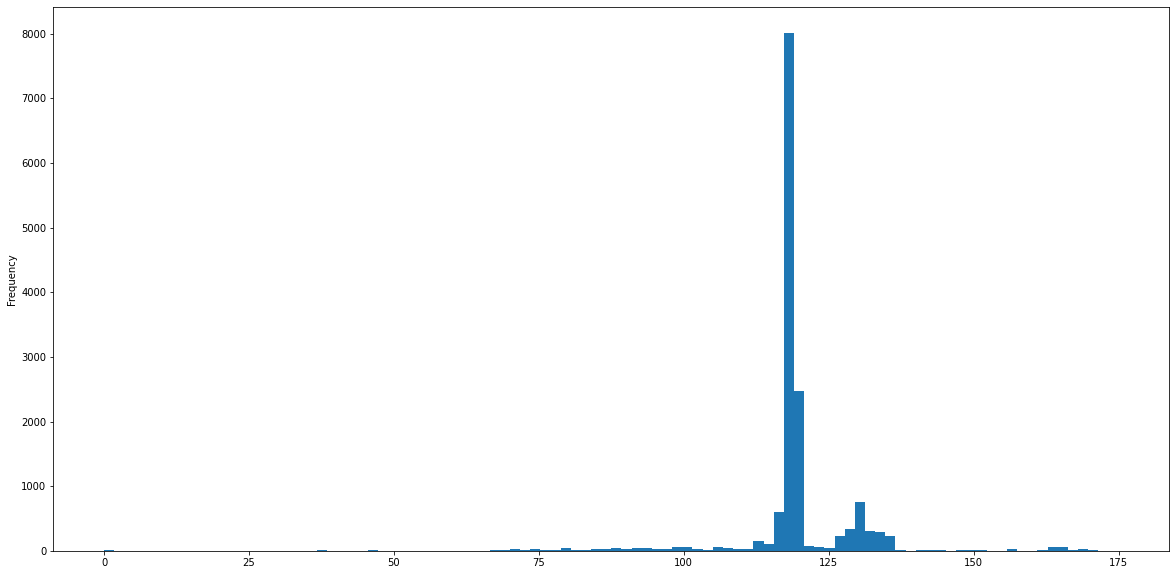

In [43]:
df[df["altitude"]>-1].altitude.plot.hist(figsize=[20,10], bins=100)
# does not exactly match:
# 54°56′15″ - 83°10′57″
# altitude above sea level: 159 m